This code is based on:

https://medium.com/@taposhdr/medical-image-analysis-with-deep-learning-i-23d518abf531


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pydicom as pdicom
import os
import copy
import scipy.ndimage
import skimage.filters as skiFilt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
from importlib import reload

from skimage.measure import label,regionprops, perimeter
from skimage.morphology import disk, dilation, remove_small_objects, erosion, closing, reconstruction, binary_closing

import frangix

reload(frangix)

%matplotlib inline

### Helper printing functions

`plti` - plots the provided image.  
`sample_stack` - plots every x slice of a 3D image stack  
`pltm` - creates a simple two column grid of the provided images  
`pltHist` - prints a histogram from the provided image or stack. Defaults to labeling as Hounsfield units

In [3]:
cmap = colors.ListedColormap(['black','white', 'green', 'red', 'blue', 'orange'])

In [4]:
def plti(im, h=8, title='',cmap='gray',**kwargs):
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none",cmap=cmap, **kwargs)
    plt.axis('off')
    plt.title(title)
    

In [5]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3, size=12,cmap='gray'):
    fig,ax = plt.subplots(rows,cols,figsize=[size,size])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        if ind < stack.shape[2]:
            ax[int(i/cols),int(i % cols)].set_title('slice %d' % ind)
            ax[int(i/cols),int(i % cols)].imshow(stack[:,:,ind],cmap)
            ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

In [6]:
def pltm(images,h=8,titles=[],cmap='gray'):
    
    imNum = len(images)
    imX   = (imNum+1)//2
    
    y = images[1].shape[0]
    x = images[1].shape[1]
    w = (y/x) * h
    
    fig = plt.figure(figsize=(w,h))
    grid = ImageGrid(fig, 111,             # similar to subplot(111)
                     nrows_ncols=(imX, 2), # creates 2x2 grid of axes
                     axes_pad=0.25,           # pad between axes in inch.
                     )

    for i in range(imNum):
        grid[i].imshow(images[i],cmap=cmap)  # The AxesGrid object work as a list of axes.
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
        if len(titles) > i :
            grid[i].set_title(titles[i])  
            
    plt.show()

In [7]:
def pltHist(image, bins=50,xlabel="Hounsfield Units (HU)",ylabel="Frequency", color='c'):

    plt.hist(image.flatten(), bins=bins, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


### Datafile Reading

This section provides the functions to read in the provided. These routines do the following:  
* Get a list of all the dicom (.dcm) files in the input directory
* Read the dicom header off the first file and save the dimensions and space
* Generate a matrix of each pixel's distance from 0, 0, 0 based in the dimensions and space obtained from the header
* Read the dicom files (one slice to a file)

In [8]:
# INPUT_FOLDER = '/Users/john/Programming/Work/AnnotatedScans/Pat1068Padded'
INPUT_FOLDER = '/Users/john/Programming/Work/Medtronic Samples/Pat002'
# INPUT_FOLDER = '/Users/john/Programming/Work/patient 1068'



In [9]:
def load_scan2(path):
    
    lstFilesDCM = []

    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():
                lstFilesDCM.append(os.path.join(dirName,filename))
#                 print(lstFilesDCM)

    lstFilesDCM.sort()
    return lstFilesDCM


In [10]:
def GetSpacing(RefDs):

    #Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = np.asarray((int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM)+1))

    #Load spacing values (in mm)
    ConstPixelSpacing = np.asarray((float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness)))

    print('Pixel Dimensions: {}'.format(ConstPixelDims))
    print('Pixel Spacing:    {}'.format(ConstPixelSpacing))

    # print(RefDs.elements)
    
    return ConstPixelDims, ConstPixelSpacing


If you're interested in the measurement from 0,0,0 to any pixel, these arrays will show that. They're not currently used anywhere after this

In [11]:
def GenDimArray(ConstPixelDims, ConstPixelSpacing, doPrint=False):
    
    x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
    z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

    if doPrint:
        print(x,y,z)
        
    return x, y, z

In [12]:
def ReadDICOM(ConstPixelDims, lstFilesDCM, RefDs):

    # The array is sized based on 'ConstPixelDims'

    newDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = pdicom.read_file(filenameDCM)
        # Store the raw image data
        newDicom[:, :, pdicom.read_file(filenameDCM).InstanceNumber] = ds.pixel_array
    
    return newDicom


### Resampling

Use the metadata from the DICOM calculate the size of each voxel as the slice thickness and resampled into 1x1x1 mm pixels and slices.  

NOTE: When finished, the slices are normalized by subtracting off the min value of the entire stack (typically -1000)

In [13]:
def resample(image, spacing, new_spacing=[1,1,1]):

    resize_factor = new_spacing / spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

def shiftHouns(image):
    
    minH = np.min(image.flatten())
    image = image - minH
    return(image)


### Read the DICOM

This code sets up the segmentation code that follows by reading in the DICOM file and resizing it to 1 x 1 x 1mm.

Pixel Dimensions: [512 512 273]
Pixel Spacing:    [0.68164062 0.68164062 1.        ]


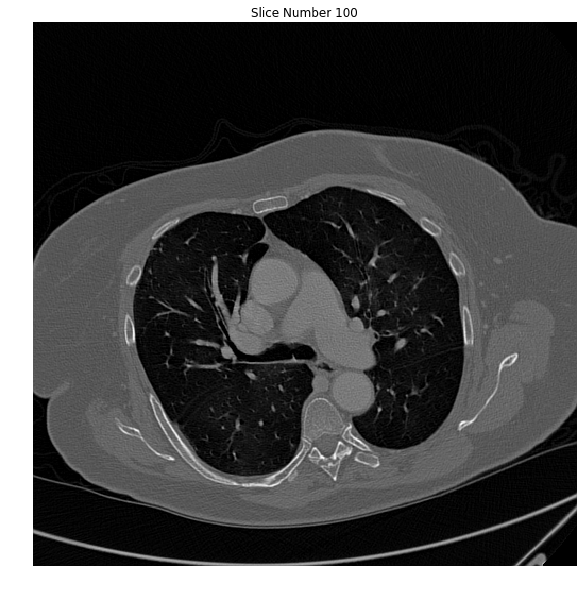

In [14]:
lstFilesDCM = load_scan2(INPUT_FOLDER)
lstFilesDCM.sort()
# print(lstFilesDCM)
    
RefDs = pdicom.read_file(lstFilesDCM[0])

ConstPixelDims, ConstPixelSpacing = GetSpacing(RefDs)
GenDimArray(ConstPixelDims, ConstPixelSpacing, False)

ArrayDicom = ReadDICOM(ConstPixelDims, lstFilesDCM, RefDs)

sliceNum = 100
plti(ArrayDicom[:, :, sliceNum],10,title = "Slice Number {}".format(sliceNum),cmap='gray')

# img_resampled, spacing = resample(ArrayDicom, ConstPixelSpacing, [1,1,1])

# print("Slice Thickness: %f" % ConstPixelSpacing[2])
# print("Pixel Spacing (row, col): (%f, %f) " % (ConstPixelSpacing[0], ConstPixelSpacing[1]))

# print("Shape before resampling\t", ArrayDicom.shape)
# print("Shape after resampling\t", img_resampled.shape)

# img_resampled = shiftHouns(img_resampled)

In [15]:
# Scan specific values:

# Pat1068
# maskLowCutoff = 2000

# Pat002
maskLowCutoff = 500


showSlice = 150

### 3D Segmentation

This is the same algorithm as that used for the 2D segmentation but for entire dicom stack. The primary changes are:
* `minAreaPct` defines how small a labeled 3D area must be considered as a useful area as a percentage of the total 3D volume
* `maxSizePct` defines how much big a labeled 3D object can be as measured by x and y dimensions as a percentage of the x and y slice dimensions
* Upon completion, the image labels are updated to remove rejected labels.

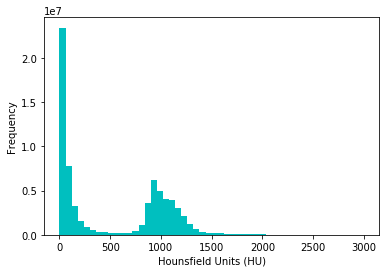

Hounsfield Units - Min:    0 Max: 3000
Labeling...
Getting initial areas
Total areas:  3716
Largest 10 areas: [8215, 8847, 8943, 11144, 49814, 142222, 475082, 1071422, 6527655, 22571222]
Removing small areas
Re-indexing remaining areas
Total remaining regions: 1
Largest 10 areas: [6527655]


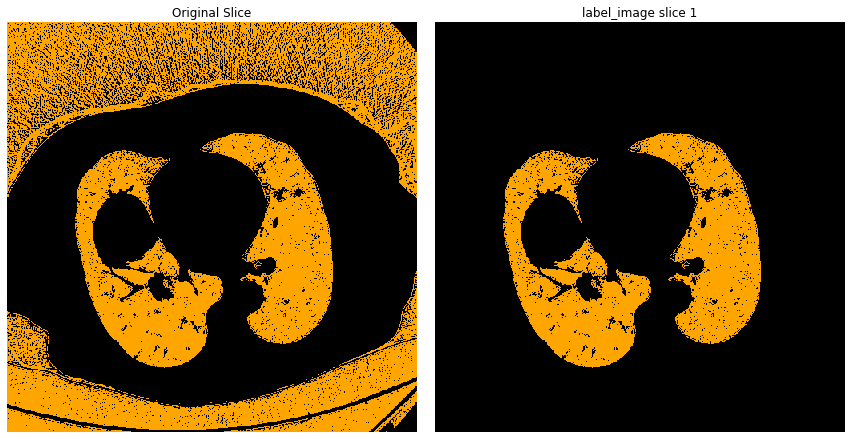

In [16]:
slice = copy.deepcopy(ArrayDicom[:, :, :])
slice[np.where(slice > 3000)] = 0

pltHist(slice)

# Convert to a binary mask after stripping off all the high Hounsfield values.
print('Hounsfield Units - Min: {:4d} Max: {:4d}'.format(np.min(slice),np.max(slice)))
slice[np.where(slice > maskLowCutoff)] = 0
slice[np.where(slice > 0)] = 1

print('Labeling...')
label_image = label(slice)

# Limits on area and size to get rid of things too big or too small
minAreaPct = 0.05
totalArea = slice.shape[0] * slice.shape[1] * slice.shape[2]
areaLimit = totalArea * minAreaPct
maxSizePct = 0.98
xMax = label_image.shape[0]*maxSizePct
yMax = label_image.shape[1]*maxSizePct

print('Getting initial areas')
areas = [r.area for r in regionprops(label_image)]
areas.sort()

topAreas = 10
print('Total areas: ',len(regionprops(label_image)))
print('Largest {} areas: {}'.format(topAreas,areas[-topAreas:]))

print('Removing small areas')
remainingRegions = []
for region in regionprops(label_image):
    xLen = region.bbox[3]-region.bbox[0]
    yLen = region.bbox[4]-region.bbox[1]
    if region.area < areaLimit or xLen > xMax or yLen > yMax :
        for coordinates in region.coords:
            label_image[coordinates[0], coordinates[1], coordinates[2]] = 0
    else:
        remainingRegions.append(region)

print('Re-indexing remaining areas')
finalRegions = []
areaX = []
idx = 1
for region in remainingRegions:
    region.label = idx
    finalRegions.append(region)
    areaX.append(region.area)
    for coordinates in region.coords:                
        label_image[coordinates[0], coordinates[1], coordinates[2]] = idx
    idx += 1

areas = [r.area for r in finalRegions]
print('Total remaining regions: {}'.format(len(finalRegions)))
print('Largest {} areas: {}'.format(topAreas,areas[-topAreas:]))

pltm([slice[:,:,showSlice],label_image[:,:,showSlice]],15,['Original Slice','label_image slice 1'],cmap=cmap)

# stepSize = 5
# show_image = label_image[:,:,:]
# sample_stack(show_image, rows=int(np.ceil(show_image.shape[2]/5/stepSize)), cols=5, size=18, start_with=0, show_every=stepSize,cmap=cmap)

# sample_stack(label_image, rows=6, cols=8, size=15)



In [19]:
imgMask = label_image > 0

print(imgMask.shape)

selem = disk(10)

for i in range(imgMask.shape[2]):
    # Closure operation with disk of radius 12
    imgMask[:,:,i] = binary_closing(imgMask[:,:,i], selem)

    # Fill in the small holes inside the lungs
    edges = skiFilt.roberts(imgMask[:,:,i])
    imgMask[:,:,i] = scipy.ndimage.binary_fill_holes(edges)

# Superimpose the mask on the input image
imgLung = copy.deepcopy(ArrayDicom[:, :, :])
get_high_vals = imgMask == 0
imgLung[get_high_vals] = 0


(512, 512, 273)


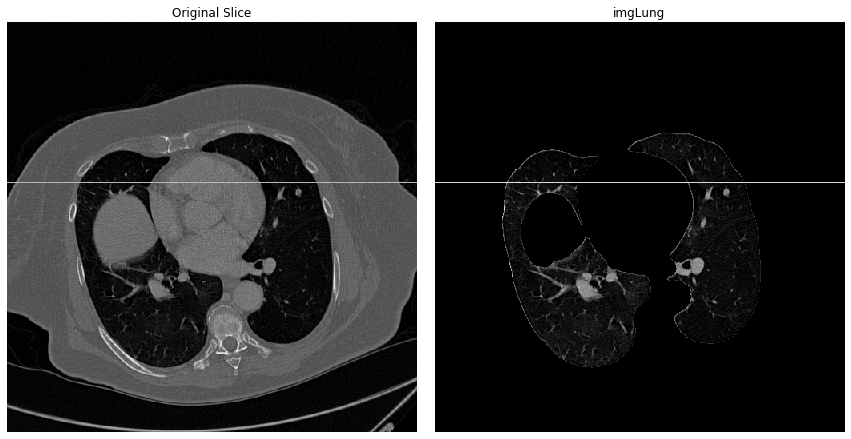

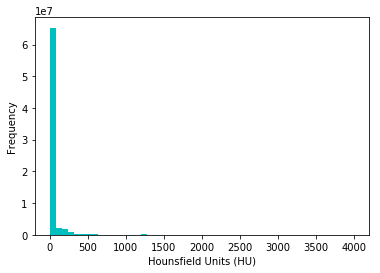

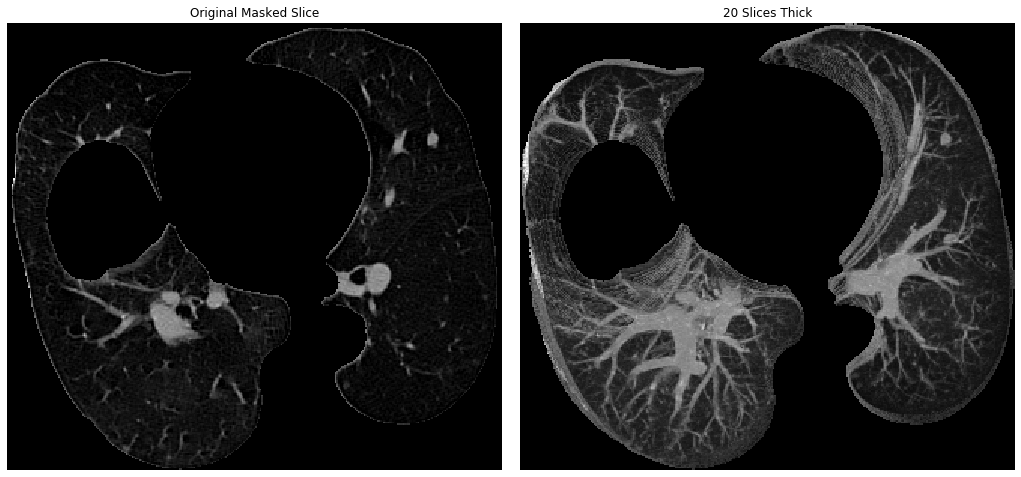

In [135]:
def fix_vector(a):
    maxVal = a[a.argmax()]
    a = a*0
    a[0] = maxVal
    return a

def trimImage(x):

    x= np.delete(x,np.where((~x.any(axis=1)).all(axis=1)), axis=0)
    x= np.delete(x,np.where((~x.any(axis=2)).all(axis=1)), axis=0)
    x= np.delete(x,np.where((~x.any(axis=0)).all(axis=1)), axis=1)

    return(x)

histLine = 200

histSlice = copy.deepcopy(ArrayDicom[:,:,showSlice])
histData = copy.deepcopy(histSlice[histLine,:])
histSlice[histLine,:] = 2000

imgSlice = copy.deepcopy(imgLung[:,:,showSlice])
imgData = copy.deepcopy(imgSlice[histLine,:])
imgSlice[histLine,:] = 2000

pltm([histSlice,imgSlice],15,['Original Slice','imgLung'],cmap='gray')

pltHist(imgLung)

sliceThickness = 20
thickSliceRange = copy.deepcopy(imgLung[:,:,showSlice:showSlice+sliceThickness])
thickSliceRange = trimImage(thickSliceRange)
thickSlice = np.apply_along_axis(fix_vector, axis=2, arr=thickSliceRange)

pltm([thickSliceRange[:,:,0],thickSlice[:,:,0]],20,['Original Masked Slice','{} Slices Thick'.format(sliceThickness)],cmap='gray')

